In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv("data.csv", comment='#',sep=',')
data.head()

,Grey Values,Size in nt in L1
0,8800.071,120.970000
1,8812.929,120.760747
2,8829.071,120.551856
3,8859.500,120.343327
4,8889.214,120.135158


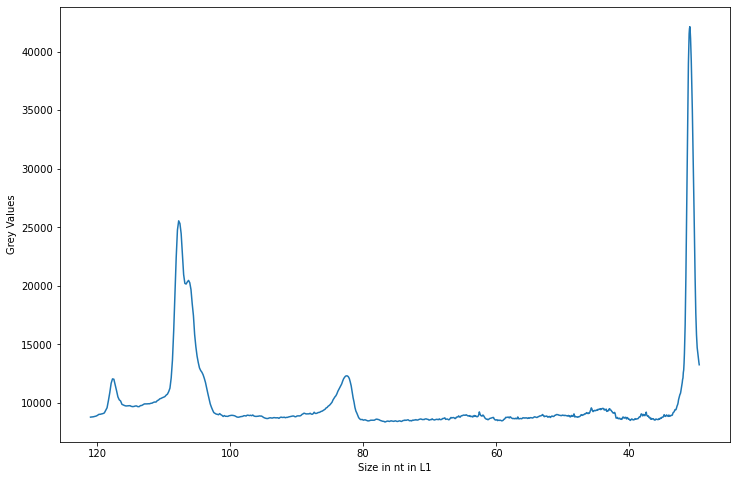

In [3]:
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], data['Grey Values'])
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

Approach 1.

Based on the algorithm called "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens (2005). 

There are two parameters: p for asymmetry and λ(lam) for smoothness. Both have to be tuned to the data at hand. It was found that generally 0.001 ≤ p ≤ 0.1 is a good choice (for a signal with positive peaks) and 10^2 ≤ λ ≤ 10^9 for lambda. 

niter → how many times the algorithm is run. 


In [27]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [28]:
# here the baseline is calculated based on the algorithm. The lam is 100000 and p is 0.05.
baseline = baseline_als(data['Grey Values'], 100000, 0.05)
new_y = data['Grey Values']-baseline
new_y

0      -180.657373
1      -197.182559
2      -210.422028
3      -209.369191
4      -209.020460
          ...     
811   -1551.579048
812   -1850.235500
813   -2157.536449
814   -2396.050315
815   -2648.467021
Name: Grey Values, Length: 816, dtype: float64

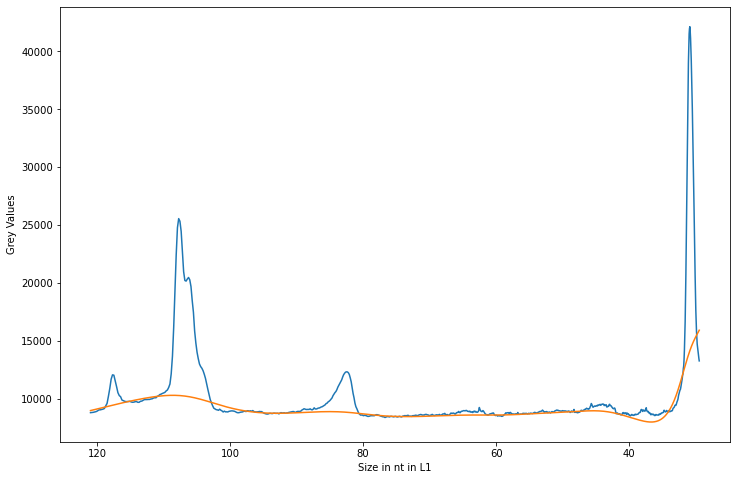

In [29]:
plt.figure(figsize=(12, 8))
plot = plt.plot(data['Size in nt in L1'], data['Grey Values'])
ax = plt.gca().invert_xaxis()
initial_plot = plt.plot(data['Size in nt in L1'], baseline)
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

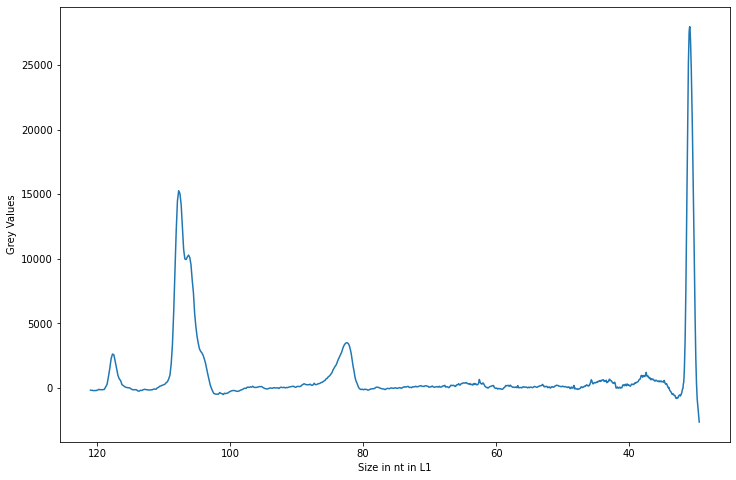

In [19]:
#with baseline removed
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], new_y)
ax = plt.gca().invert_xaxis()
#plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

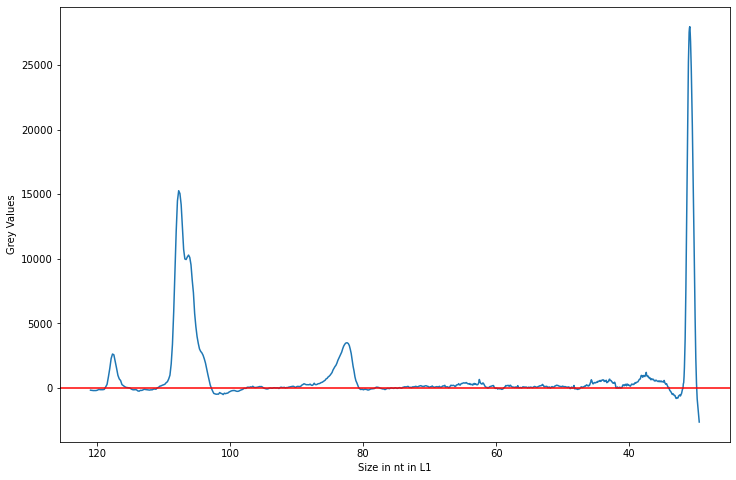

In [20]:
# negative values
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], new_y)
ax = plt.gca().invert_xaxis()
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

Approach 2. 

There are several libraries for baseline fitting, for example 'pybaselines'. There are many ways to detect a baseline and many algorithms to choose from.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

from pybaselines import Baseline
from pybaselines.utils import gaussian


In [34]:
baseline_fitter = Baseline(x_data=data['Size in nt in L1'])
modpoly = baseline_fitter.modpoly(data['Grey Values'], poly_order=3)
imodpoly = baseline_fitter.imodpoly(data['Grey Values'], poly_order=3, num_std=0.7)

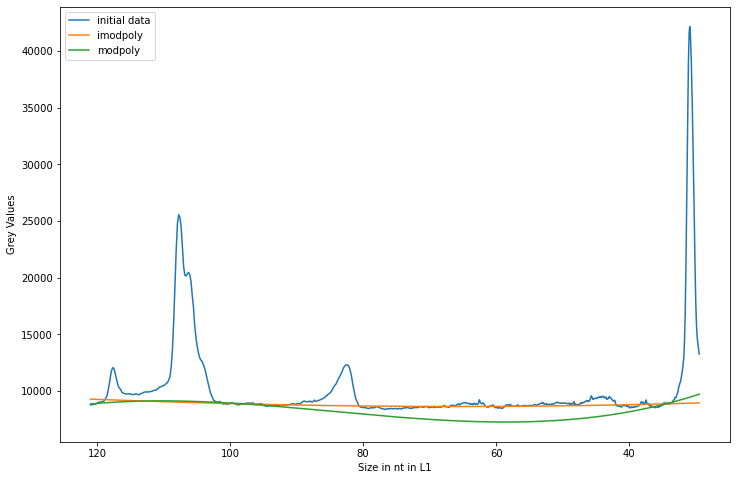

In [56]:
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], data['Grey Values'], label='initial data')
ax = plt.gca().invert_xaxis()
plt.plot(data['Size in nt in L1'], imodpoly[0], label='imodpoly')
plt.plot(data['Size in nt in L1'], modpoly[0], label='modpoly')
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

In [44]:
new_y_imod = data['Grey Values']-imodpoly[0]

0      -501.953316
1      -484.342976
2      -463.473003
3      -428.340315
4      -393.946824
          ...     
811    5183.835459
812    4939.219466
813    4685.817679
814    4501.130105
815    4302.514745
Name: Grey Values, Length: 816, dtype: float64

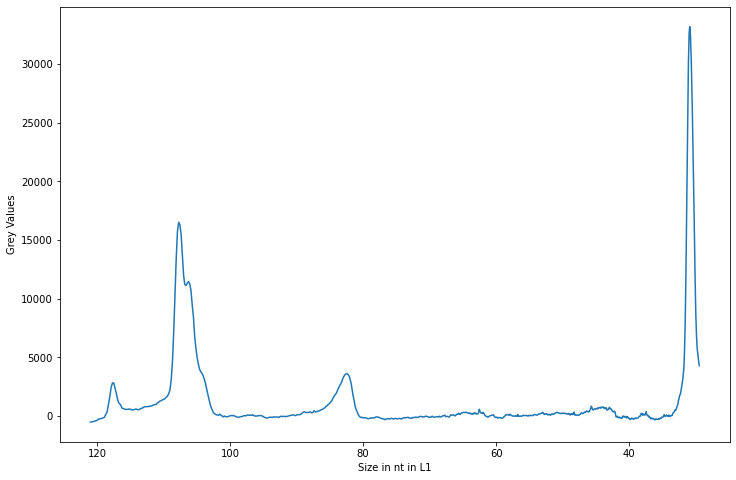

In [45]:
#with baseline removed
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], new_y_imod)
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

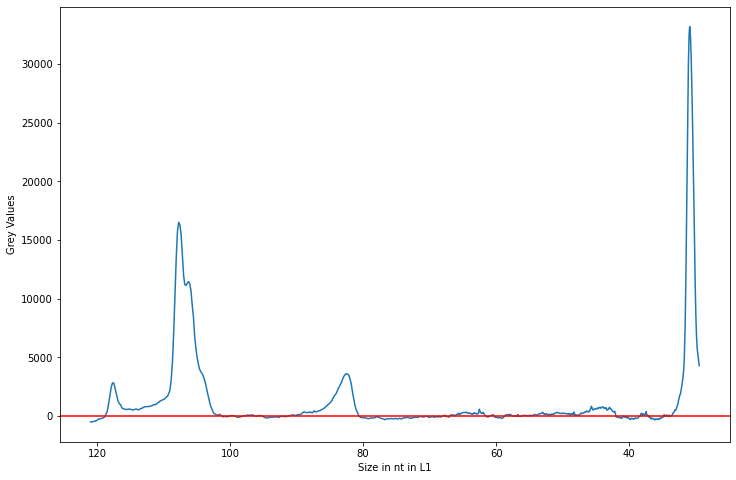

In [46]:
# negative values
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data['Size in nt in L1'], new_y_imod)
ax = plt.gca().invert_xaxis()
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

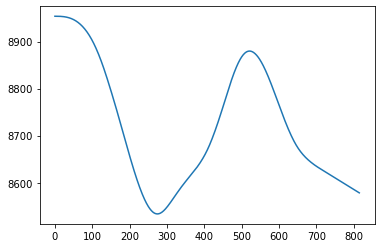

In [53]:
lam = 1e6
plt.plot(baseline_fitter.arpls(data["Grey Values"], lam = lam)[0], label=f'lam={lam:.0f}')

https://pybaselines.readthedocs.io/en/latest/examples/index.html